# **Movies Dataset Collaborative Filtering Model Using Fast.AI**

## **Collaborators** 
- Ashna Sood 
- Urmi Suresh
- Tae Kim 
- Xianglong Wang

## **Imports** 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os 
import pickle
import math

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import make_scorer, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer

from sklearn import metrics

from fastai.tabular.all import *
from fastai.collab import *

## **Collaborative Filtering using ratings_small data**

In [2]:
# read in movie ratings 
ratings_df = pd.read_csv('Movies Data/ratings_small.csv')

# rename columns
ratings_df = ratings_df.rename(columns={"userId": "User ID", 
                                        "movieId": "Movie ID", 
                                        "timestamp": "Timestamp"})

In [3]:
ratings_df

,User ID,Movie ID,rating,Timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [4]:
# check for null values
ratings_df.isnull().any()

User ID      False
Movie ID     False
rating       False
Timestamp    False
dtype: bool

In [5]:
# read in movies ID map csv file
movies_ID_map = pd.read_csv("movies_ID_map.csv")
movies_ID_map

,Title,ID,Movie ID
0,Queerama,461257,176279
1,Willie and Phil,92323,112577
2,Brother Rat,114838,112548
3,Le pélican,264723,112510
4,"So Evil, So Young",88061,112467
...,...,...,...
42272,Deadpool,293660,122904
42273,The Avengers,24428,89745
42274,Avatar,19995,72998
42275,The Dark Knight,155,58559


In [6]:
movie_titles = pd.DataFrame(movies_ID_map[["Movie ID", "Title"]])
movie_titles

,Movie ID,Title
0,176279,Queerama
1,112577,Willie and Phil
2,112548,Brother Rat
3,112510,Le pélican
4,112467,"So Evil, So Young"
...,...,...
42272,122904,Deadpool
42273,89745,The Avengers
42274,72998,Avatar
42275,58559,The Dark Knight


In [7]:
ratings = ratings_df.merge(movie_titles, on = "Movie ID")

ratings = ratings.sort_values(by="User ID")

ratings = ratings[["User ID", "Movie ID", "Title", "rating"]]
ratings

,User ID,Movie ID,Title,rating
0,1,31,Dangerous Minds,2.5
84,1,1061,Sleepers,3.0
117,1,1129,Escape from New York,2.0
849,1,3671,Blazing Saddles,3.0
806,1,2968,Time Bandits,1.0
...,...,...,...,...
53115,671,3386,JFK,4.0
17612,671,1240,The Terminator,4.0
57306,671,5218,Ice Age,2.0
8118,671,589,Terminator 2: Judgment Day,5.0


### Collaborative Filtering using Fast.AI packages

Following and Inspired by Fast.AI collaborative filtering tutorial: https://docs.fast.ai/tutorial.collab.html 

In [8]:
# create data loaders 
dls = CollabDataLoaders.from_df(ratings, user_name = "User ID", item_name = "Title", rating_name = "rating", bs=64)

In [9]:
dls.show_batch()

,User ID,Title,rating
0,57,Friday the 13th Part 2,2.0
1,428,The Usual Suspects,4.5
2,388,Planet of the Apes,1.0
3,373,When We Were Kings,5.0
4,580,Lethal Weapon 2,3.5
5,564,Interview with the Vampire,5.0
6,624,Shadow Dancer,3.0
7,239,Cocoon: The Return,3.0
8,559,The Right Stuff,5.0
9,353,Hellboy,2.5


In [10]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [11]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.844656,0.848827,00:10
1,0.771783,0.783484,00:10
2,0.586976,0.759781,00:10
3,0.427933,0.754216,00:10
4,0.319195,0.755374,00:10


In [12]:
g = ratings.groupby("Title")["rating"].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Forrest Gump', 'Pulp Fiction', 'The Shawshank Redemption',
       'The Silence of the Lambs', 'Star Wars', 'Jurassic Park',
       'The Matrix', 'Toy Story', "Schindler's List",
       'Terminator 2: Judgment Day'], dtype=object)

In [13]:
# grab bias of each movie
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = ratings.groupby("Title")["rating"].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [17]:
# movies with the worst bias
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.2298), 'Batman & Robin', 2.148936170212766),
 (tensor(-0.2036), 'Wild Wild West', 2.0319148936170213),
 (tensor(-0.1947), 'Lost in Space', 2.1346153846153846),
 (tensor(-0.1737), 'Pocahontas', 2.9262295081967213),
 (tensor(-0.1579), 'The Blair Witch Project', 2.738372093023256),
 (tensor(-0.1569), 'Mission to Mars', 2.2666666666666666),
 (tensor(-0.1568), 'Striptease', 2.4615384615384617),
 (tensor(-0.1404), 'Airheads', 2.3076923076923075),
 (tensor(-0.1389), 'Home Alone 2: Lost in New York', 2.467741935483871),
 (tensor(-0.1373), 'Ace Ventura: When Nature Calls', 2.597826086956522),
 (tensor(-0.1356), 'I Know What You Did Last Summer', 2.5166666666666666),
 (tensor(-0.1313), 'Anaconda', 2.017857142857143),
 (tensor(-0.1257), 'Honey, I Shrunk the Kids', 2.7434210526315788),
 (tensor(-0.1256), 'The Island of Dr. Moreau', 2.38),
 (tensor(-0.1198), 'Showgirls', 2.3142857142857145)]

In [19]:
# movies with best bias
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5237), 'The Shawshank Redemption', 4.487138263665595),
 (tensor(0.3937), 'The Fugitive', 3.9530516431924885),
 (tensor(0.3802), 'Pulp Fiction', 4.256172839506172),
 (tensor(0.3724), 'Monty Python and the Holy Grail', 4.224137931034483),
 (tensor(0.3718), "Schindler's List", 4.30327868852459),
 (tensor(0.3590), 'The Silence of the Lambs', 4.1381578947368425),
 (tensor(0.3515), 'The Matrix', 4.183397683397684),
 (tensor(0.3471), 'Life Is Beautiful', 4.025252525252525),
 (tensor(0.3411), 'Stand by Me', 4.09375),
 (tensor(0.3361), 'Forrest Gump', 4.05425219941349),
 (tensor(0.3331), 'Fargo', 4.256696428571429),
 (tensor(0.3300), 'The Imitation Game', 4.109375),
 (tensor(0.3295), 'Amadeus', 4.155),
 (tensor(0.3274), 'Harry Potter and the Half-Blood Prince', 4.068965517241379),
 (tensor(0.3270), 'The Usual Suspects', 4.370646766169155)]

In [20]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

applying PCA to reduce the dimensions and see what model learned

In [21]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [22]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [23]:
# highest score on the first dimension
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1470), 'Down Periscope'),
 (tensor(1.1207), 'Anaconda'),
 (tensor(1.1107), 'Lost in Space'),
 (tensor(0.9644), 'Daredevil'),
 (tensor(0.9145), 'Striptease'),
 (tensor(0.8992), 'Mission to Mars'),
 (tensor(0.8853), 'Armageddon'),
 (tensor(0.8818), 'Wild Wild West'),
 (tensor(0.8697), 'Coyote Ugly'),
 (tensor(0.8694), 'Pearl Harbor')]

In [24]:
# worst score on the first dimension
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0881), 'The Godfather'),
 (tensor(-0.9069), 'Chinatown'),
 (tensor(-0.8752), 'All About Eve'),
 (tensor(-0.8171), 'Ran'),
 (tensor(-0.8030), 'Fargo'),
 (tensor(-0.7972), 'On the Waterfront'),
 (tensor(-0.7899),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb'),
 (tensor(-0.7797), 'Psycho'),
 (tensor(-0.7492), 'The Godfather: Part II'),
 (tensor(-0.7376), 'The Maltese Falcon')]

In [25]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [26]:
# highest score on the second dimension
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9074), 'The Lord of the Rings: The Return of the King'),
 (tensor(0.7985), 'The Lord of the Rings: The Fellowship of the Ring'),
 (tensor(0.7980), 'The Lord of the Rings: The Two Towers'),
 (tensor(0.7114), 'Shrek'),
 (tensor(0.6828), 'Star Wars'),
 (tensor(0.6677), 'Finding Nemo'),
 (tensor(0.6625), 'Braveheart'),
 (tensor(0.6440), 'The Dark Knight'),
 (tensor(0.5956), "Harry Potter and the Philosopher's Stone"),
 (tensor(0.5904), 'Gran Torino')]

In [27]:
# worst score on the first dimension
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.7554), 'The Island of Dr. Moreau'),
 (tensor(-0.7338), "Rosemary's Baby"),
 (tensor(-0.7303), 'Tank Girl'),
 (tensor(-0.6935), 'Mission to Mars'),
 (tensor(-0.6763), 'Sex, Lies, and Videotape'),
 (tensor(-0.6418), 'Scary Movie'),
 (tensor(-0.6400), 'Heavenly Creatures'),
 (tensor(-0.6227), 'Easy Rider'),
 (tensor(-0.6143), 'Anaconda'),
 (tensor(-0.5833), 'Babe: Pig in the City')]

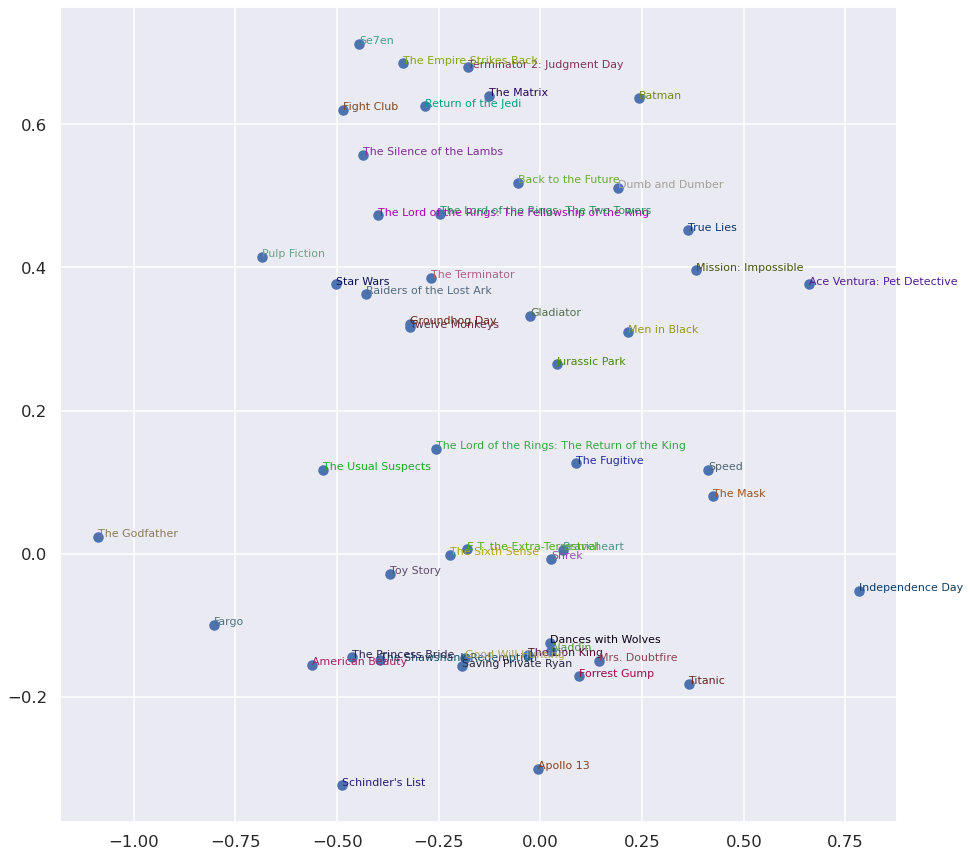

In [28]:
# plot movies according to their scores
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

From this plot, it is evident that movies with similar features and genres are near each other. 

### Collaborative Filtering using Surpise Package and SVD model

Collaborative filtering is an algorithm that creates recommendations based on data collected from other users, using the assumption that users who have similar interests in certain items are more likely to see eye to eye again. This stems from the idea that if we have friends who share our similar interests, then we would trust their recommendations in the future simply because we think we have the same tastes. Our collaborative filtering algorithm uses the similarity index technique where a certain number of users are chosen based on how similar they are to the user we are focusing on. The algorithm to calculate this is Signular Value Decompositon (SVD), which is a matrix factorization technique that reduces the number of features of a dataset. In the context of collaborative filtering, each row is a user and each column is a movie item, and the values in the matrix are the user ratings.  Then a weighted average of the selected users is created and that number provides the suggestions for the focused user. 

In [2]:
#!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import dump

In [4]:
reader = Reader()

In [8]:
data = Dataset.load_from_df(ratings_df[['User ID', 'Movie ID', 'rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7965  0.7962  0.7956  0.7962  0.7960  0.7961  0.0003  
MAE (testset)     0.6023  0.6025  0.6019  0.6023  0.6021  0.6022  0.0002  
Fit time          685.16  694.63  693.42  692.81  695.55  692.31  3.70    
Test time         57.71   58.90   49.77   49.97   46.38   52.54   4.88    


{'test_rmse': array([0.79654272, 0.79619573, 0.79561253, 0.79622099, 0.79598232]),
 'test_mae': array([0.60225976, 0.60245458, 0.60187422, 0.6023217 , 0.6021279 ]),
 'fit_time': (685.1593697071075,
  694.6251404285431,
  693.4244229793549,
  692.8122618198395,
  695.5460493564606),
 'test_time': (57.705753564834595,
  58.895099401474,
  49.7657413482666,
  49.96788167953491,
  46.383798360824585)}

In [9]:
training_data = data.build_full_trainset()
algo.fit(training_data)

Surprise package predict method takes in: 
- uid = user ID
- iid = item id 
- rui = true rating -- optional

In [ ]:
algo.predict(1, 302, 3).est

In [ ]:
# Dump algorithm to save 
file_name = "SVD_model_ex"
dump.dump(file_name, algo=algo)

### Reload Collaboraitve Filtering Model

In [17]:
# reload algorithm
from surprise import dump
file_name = "SVD_model_ex"
_, loaded_algo = dump.load(file_name)

## Hybrid Recommender combining Content Based and Collaborative Filtering Models

**Hybrid Recommender combining content based model and collaborative filtering model. Going to input the User ID and title of the movie and return top 20 movies that are similar based on both the metadata of the input movie and the user's preferences and predicted ratings of those movies.**

In [8]:
movies_df

,index,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
0,0,461257,tt6980792,Queerama,NaN,[],en,['en'],2017-06-09,75.0,...,['United Kingdom'],0.163015,NaN,NaN,[],[],daisyasquith,NaN,NaN,daisyasquith
1,1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,...,[],0.326500,NaN,NaN,[],"['michaelontkean', 'raysharkey', 'margotkidder']",paulmazursky,paulmazursky,NaN,paulmazursky paulmazursky michaelontkean rays...
2,2,114838,tt0029949,Brother Rat,NaN,['Comedy'],en,['en'],1938-10-29,87.0,...,['United States of America'],0.174691,NaN,NaN,['basedonplayormusical'],"['ronaldreagan', 'janewyman', 'priscillalane',...",williamkeighley,jerrywald,NaN,williamkeighley jerrywald Comedy ronaldreagan...
3,3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,...,[],0.000115,NaN,NaN,[],[],gérardblain,NaN,NaN,gérardblain
4,4,88061,tt0055459,"So Evil, So Young",NaN,['Drama'],en,['en'],1963-01-01,77.0,...,[],0.001662,NaN,NaN,"['prison', ""women'sprison""]","['jillireland', 'ellenpollock', 'joanhaythorne...",godfreygrayson,markgrantham,NaN,godfreygrayson markgrantham Drama jillireland...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42273,42273,24428,tt0848228,The Avengers,theavengerscollection,"['Science Fiction', 'Action', 'Adventure']",en,['en'],2012-04-25,143.0,...,['United States of America'],89.887648,12000.0,7.4,"['newyork', 'shield', 'marvelcomic', 'superher...","['robertdowneyjr.', 'chrisevans', 'markruffalo...",josswhedon,josswhedon,stanlee,josswhedon josswhedon stanlee theavengerscolle...
42274,42274,19995,tt0499549,Avatar,avatarcollection,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,"['en', 'es']",2009-12-10,162.0,...,"['United States of America', 'United Kingdom']",185.070892,12114.0,7.2,"['cultureclash', 'future', 'spacewar', 'spacec...","['samworthington', 'zoesaldana', 'sigourneywea...",jamescameron,jamescameron,jamescameron,jamescameron jamescameron jamescameron avatarc...
42275,42275,155,tt0468569,The Dark Knight,thedarkknightcollection,"['Drama', 'Action', 'Crime', 'Thriller']",en,"['en', 'zh']",2008-07-16,152.0,...,"['United Kingdom', 'United States of America']",123.167259,12269.0,8.3,"['dccomics', 'crimefighter', 'secretidentity',...","['christianbale', 'michaelcaine', 'heathledger...",christophernolan,christophernolan,charlesroven,christophernolan christophernolan charlesroven...
42276,42276,27205,tt1375666,Inception,NaN,"['Action', 'Thriller', 'Science Fiction', 'Mys...",en,['en'],2010-07-14,148.0,...,"['United Kingdom', 'United States of America']",29.108149,14075.0,8.1,"['lossoflover', 'dream', 'kidnapping', 'sleep'...","['leonardodicaprio', 'josephgordon-levitt', 'e...",christophernolan,christophernolan,christophernolan,christophernolan christophernolan christophern...


In [9]:
# read in movies ID map csv file
movies_ID_map = pd.read_csv("movies_ID_map.csv")
movies_ID_map

,Title,ID,Movie ID
0,Queerama,461257,176279
1,Willie and Phil,92323,112577
2,Brother Rat,114838,112548
3,Le pélican,264723,112510
4,"So Evil, So Young",88061,112467
...,...,...,...
42272,Deadpool,293660,122904
42273,The Avengers,24428,89745
42274,Avatar,19995,72998
42275,The Dark Knight,155,58559


We chose to ultimately create a Hybrid Recommender Model that combined the content based model and collaborative filtering model because we wanted to create a recommender that used both the user’s past preferences as well as other user’s preferences who were similar to the active user. To do this our initial goal was to input the User ID and title of the movie we wanted similar movies for and to output the top 20 movies that were similar to the input movie based on both the metadata of the input movie and the user’s preferences and predicted ratings of those movies. Thus, the movies that are recommended from this hybrid model are not only preferenced by similar movie features but also a predicted higher rating that the user would give to that movie. 

In [11]:
# method that produces recommendations based off of both metadata and user preferences
def hybrid_recommender(userID, title):
    index = indices[title]
    tmdbId = movies_ID_map.loc[movies_ID_map["Title"] == title]['ID']
    movie_id = movies_ID_map.loc[movies_ID_map["Title"] == title]['Movie ID']
    
    # take top 20 movies based on similarity scores to calculate the vote of the 60th percentile movie
    # then calculate the weighted rating of each movie using IMDB formula 
    sim_scores = list(enumerate(cosine_sim_loaded[int(index)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    similar_movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_df.iloc[similar_movie_indices][['Title', 'Vote Count', 'Vote Average', 'ID']]
    similar_movies_IDs = list(map(int, movies["ID"].values))

    for ID, index in zip(similar_movies_IDs, similar_movie_indices):
        movieID = int(movies_ID_map.loc[movies_ID_map["ID"] == ID]['Movie ID'])
        est_rating = loaded_algo.predict(userID, movieID).est
        movies.loc[index, "est"] = est_rating
        
    movies = movies.sort_values('est', ascending=False)
    return movies

Basic Testing of the Hybrid Recommender Comparing between User 10 and User 35

In [80]:
hybrid_recommender(10, 'The Avengers')

,Title,Vote Count,Vote Average,ID,est
42262,Iron Man,8951.0,7.4,1726,4.358564
36165,Team Thor,93.0,7.5,413279,4.226156
41411,Serenity,1287.0,7.4,16320,4.225701
42248,Captain America: Civil War,7462.0,7.1,271110,4.222177
42272,Deadpool,11444.0,7.4,293660,4.203255
32729,Marvel Studios: Assembling a Universe,44.0,6.6,259910,4.160966
42263,Iron Man 3,8951.0,6.8,68721,4.054722
42206,Doctor Strange,5880.0,7.1,284052,4.051236
42207,Captain America: The Winter Soldier,5881.0,7.6,100402,4.002187
42243,Captain America: The First Avenger,7174.0,6.6,1771,3.992446


In [81]:
hybrid_recommender(35, 'The Avengers')

,Title,Vote Count,Vote Average,ID,est
41411,Serenity,1287.0,7.4,16320,4.361905
42206,Doctor Strange,5880.0,7.1,284052,4.153873
42262,Iron Man,8951.0,7.4,1726,4.126833
36165,Team Thor,93.0,7.5,413279,4.112717
32729,Marvel Studios: Assembling a Universe,44.0,6.6,259910,4.099205
42248,Captain America: Civil War,7462.0,7.1,271110,4.091808
42272,Deadpool,11444.0,7.4,293660,4.054944
42216,Ant-Man,6029.0,7.0,102899,4.043048
42207,Captain America: The Winter Soldier,5881.0,7.6,100402,3.992822
42240,Avengers: Age of Ultron,6908.0,7.3,99861,3.966149


In [83]:
hybrid_recommender(10, 'Mean Girls')

,Title,Vote Count,Vote Average,ID,est
31692,Puella Magi Madoka Magica the Movie Part III: ...,36.0,7.3,212162,4.394826
14299,Live from New York!,5.0,5.4,334328,3.755567
34656,Just One of the Guys,64.0,6.4,24548,3.754710
38215,Geek Charming,188.0,6.0,81250,3.725091
28333,Screwballs,22.0,4.7,25164,3.665975
35695,Frenemies,83.0,5.2,84105,3.548348
39125,It's a Boy Girl Thing,279.0,6.3,37725,3.443764
37231,Zapped,131.0,5.6,278774,3.432579
41469,The DUFF,1372.0,6.8,272693,3.397726
35992,The Cheetah Girls,90.0,4.9,32293,3.391446


In [84]:
hybrid_recommender(35, 'Mean Girls')

,Title,Vote Count,Vote Average,ID,est
31692,Puella Magi Madoka Magica the Movie Part III: ...,36.0,7.3,212162,4.404914
14299,Live from New York!,5.0,5.4,334328,3.952208
35695,Frenemies,83.0,5.2,84105,3.521542
39125,It's a Boy Girl Thing,279.0,6.3,37725,3.472875
34656,Just One of the Guys,64.0,6.4,24548,3.401603
38215,Geek Charming,188.0,6.0,81250,3.387064
35099,How to Build a Better Boy,71.0,5.7,286987,3.364189
28333,Screwballs,22.0,4.7,25164,3.328902
37231,Zapped,131.0,5.6,278774,3.312382
41469,The DUFF,1372.0,6.8,272693,3.311737
